In [2]:
import os
import math
import random as rand
from tqdm import tqdm, trange

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModel, TFBertForSequenceClassification
from datasets import Dataset
import evaluate

import tensorflow as tf

from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

# Data Loading

In [3]:
dataset = 'title_abstract_keywords'

In [4]:
df = pd.read_pickle("data/train_{}.pkl".format(dataset))

In [5]:
df.head()

,label,text
0,1,Comparing measurement properties of EQ-5D-Y-3L...
1,0,Feasibility of the EQ-5D in the elderly popula...
2,1,Comparing the self-reported health-related qua...
3,1,Testing measurement properties of two EQ-5D yo...
4,1,Use of Antimalarial Agents is Associated with ...


In [6]:
train_dataset = Dataset.from_pandas(df)

In [7]:
train_dataset[0]

{'label': 1,
 'text': 'Comparing measurement properties of EQ-5D-Y-3L and EQ-5D-Y-5L in paediatric patients [SEP] BACKGROUND: The adult versions EQ-5D-3L and EQ-5D-5L have been extensive compared. This is not the case for the EQ-5D youth versions. The study aim was to compare the measurement properties and responsiveness of EQ-5D-Y-3L and EQ-5D-Y-5L in paediatric patients. METHODS: A sample of patients 8-16\xa0years old with different diseases and a wide range of disease severity was asked to complete EQ-5D-Y-3L, EQ-5D-Y-5L, PedsQL Generic Core Scale, and selected, appropriate disease-specific instruments, three times. EQ-5D-Y-3L and EQ-5D-Y-5L were compared in terms of: feasibility, (re-)distribution properties, discriminatory power, convergent validity, test-retest reliability, and responsiveness. RESULTS: 286 participating patients suffered from one of the following diseases: major beta-thalassemia, haemophilia, acute lymphoblastic leukaemia, acute illness. Missing responses were co

In [8]:
#random stratified validation subset split
#_diff = 1
#while _diff >= .02:
#    tts = train_dataset.train_test_split(test_size=.15, shuffle=True)
#    _train_ratio, _val_ratio = np.sum(tts["train"]["label"]) / len(tts["train"]["label"]), np.sum(tts["test"]["label"]) / len(tts["test"]["label"])
#    _diff = abs(_train_ratio - _val_ratio)
#    print(_train_ratio, _val_ratio, _diff)
#
#train_dataset = tts["train"]
#val_dataset = tts["test"]


#subsets should be fixed for all tests
_val_ids = [2, 7, 24, 32, 36, 47, 49, 59, 61, 71, 72, 86, 90, 95, 96]
train_dataset = Dataset.from_pandas(df[~df.index.isin(_val_ids)])
val_dataset = Dataset.from_pandas(df[df.index.isin(_val_ids)])

In [9]:
np.sum(train_dataset["label"]) / len(train_dataset["label"]), np.sum(val_dataset["label"]) / len(val_dataset["label"])

(0.611764705882353, 0.6)

In [10]:
train_dataset[0]

{'label': 1,
 'text': 'Comparing measurement properties of EQ-5D-Y-3L and EQ-5D-Y-5L in paediatric patients [SEP] BACKGROUND: The adult versions EQ-5D-3L and EQ-5D-5L have been extensive compared. This is not the case for the EQ-5D youth versions. The study aim was to compare the measurement properties and responsiveness of EQ-5D-Y-3L and EQ-5D-Y-5L in paediatric patients. METHODS: A sample of patients 8-16\xa0years old with different diseases and a wide range of disease severity was asked to complete EQ-5D-Y-3L, EQ-5D-Y-5L, PedsQL Generic Core Scale, and selected, appropriate disease-specific instruments, three times. EQ-5D-Y-3L and EQ-5D-Y-5L were compared in terms of: feasibility, (re-)distribution properties, discriminatory power, convergent validity, test-retest reliability, and responsiveness. RESULTS: 286 participating patients suffered from one of the following diseases: major beta-thalassemia, haemophilia, acute lymphoblastic leukaemia, acute illness. Missing responses were co

In [11]:
df = pd.read_pickle("data/test_{}.pkl".format(dataset))

In [12]:
test_dataset = Dataset.from_pandas(df)

In [13]:
np.sum(test_dataset["label"]) / len(test_dataset["label"])

0.6

# Preparation for training

In [14]:
tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16")

In [15]:
#def preprocess_function(examples):
#    return tokenizer(examples["text"], truncation=True, padding=True)

In [16]:
#encodings = dataset.map(preprocess_function, batched=True)
train_encodings = tokenizer(train_dataset["text"], truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_dataset["text"], truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_dataset["text"], truncation=True, padding=True, max_length=512)

In [17]:
len(train_encodings[0]), len(train_encodings[1]), len(train_encodings[2])

(512, 512, 512)

In [18]:
np.mean([np.sum([t == '[PAD]' for t in train_encodings[e].tokens]) for e in range(0,80)])

52.575

In [19]:
train_labels = train_dataset["label"]
val_labels = val_dataset["label"]
test_labels = test_dataset["label"]

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).shuffle(100).batch(16)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).shuffle(100).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
)).batch(16)

In [21]:
model = TFBertForSequenceClassification.from_pretrained('bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16', from_pt=True)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
model.layers[0].trainable = False

In [23]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  335141888 
                                                                 
 dropout_73 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2050      
                                                                 
Total params: 335,143,938
Trainable params: 2,050
Non-trainable params: 335,141,888
_________________________________________________________________


In [24]:
model.compile(optimizer="adam", loss=loss, metrics=['sparse_categorical_accuracy'])

In [25]:
es = tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)
hist = model.fit(train_dataset, 
                 epochs=1000, 
                 validation_data=val_dataset,
                 callbacks=[es],
                 verbose=0)

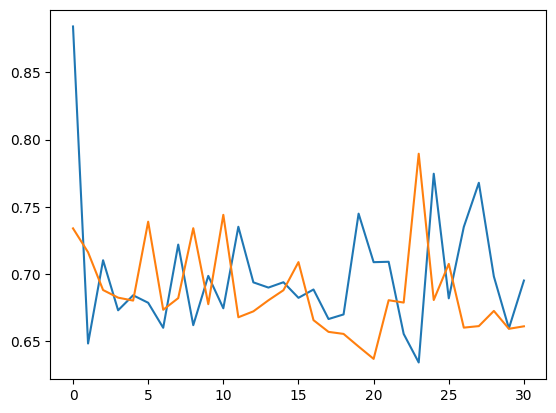

In [26]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])

### results

In [27]:
model.evaluate(test_dataset)

7/7 [==============================] - 73s 10s/step - loss: 0.6721 - sparse_categorical_accuracy: 0.6000


[0.6721099615097046, 0.6000000238418579]

In [28]:
predraw = model.predict(test_dataset, verbose=0)

In [29]:
def softmax(z):
    assert len(z.shape) == 2
    s = np.max(z, axis=1)
    s = s[:, np.newaxis] # necessary step to do broadcasting
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] # dito
    return e_x / div

In [30]:
predsoftmax = softmax(predraw.logits.astype(np.float32))

In [31]:
test_labels = np.array(test_labels)

In [32]:
test_predictions = np.argmax(predraw.logits, axis=1)

In [33]:
np.sum(np.argmax(predsoftmax, axis=1) == np.array(test_labels))

60

In [34]:
confusionMatrix = confusion_matrix(test_labels,test_predictions)

In [ ]:
macroF1 = f1_score(test_labels,test_predictions, average = 'macro')
microF1 = f1_score(test_labels,test_predictions, average = 'micro')
weightedF1 = f1_score(test_labels,test_predictions, average = 'weighted')

macroRecall = recall_score(test_labels, test_predictions, average='macro')
microRecall = recall_score(test_labels, test_predictions, average='micro')
weightedRecall = recall_score(test_labels, test_predictions, average='weighted')

macroPrecision = precision_score(test_labels, test_predictions, average='macro')
microPrecision = precision_score(test_labels, test_predictions, average='micro')
weightedPrecision = precision_score(test_labels, test_predictions, average='weighted')


print ("Confusion Matrix:", "\n", confusionMatrix, "\n", 
       "F Scores:", "\n", "macro F1:", macroF1,"micro F1:", microF1, "weighted F1:", weightedF1, "\n",
       "Recall scores:", "\n", "macro Recall:", macroRecall, "micro Recall:", microRecall, "weighted Recall:", weightedRecall, "\n",
       "Precision scores", "\n", "macro Precision:", macroPrecision, "micro Precision:", microPrecision, "weighted Precision:", weightedPrecision)

In [36]:
#TODO: collect results and write to a log

In [37]:
with open("init_results-{}-{}.txt".format("bluebert", dataset), "w") as text_file:
    text_file.write("{};{};{};{};{}".format("bluebert", dataset, weightedPrecision, weightedRecall, weightedF1))